# Quickstart Example with Basic Synthetic Simulation (Customization)
This notebook provides an example of customizing the basic environment.

This example on Basic Synthetic Simulation consists of the following 3 steps:
1. Setup Synthetic Environment and Interacting Online RL Agent
2. Standardized Environment
3. Customize Environmental Configuration

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations.  

In [6]:
# import SCOPE-RL modules
import scope_rl
from scope_rl.policy import OnlineHead
from scope_rl.policy import EpsilonGreedyHead

# import synthetic modules
from basicgym import BasicEnv
from basicgym import BaseRewardFunction
from basicgym import BaseStateTransitionFunction

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy
from d3rlpy.algos import RandomPolicy as ContinuousRandomPolicy
from d3rlpy.preprocessing import MinMaxActionScaler

# import from other libraries
import gym
from sklearn.utils import check_random_state
from sklearn.utils import check_scalar

In [7]:
from dataclasses import dataclass
from typing import Tuple, Union, Optional

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [8]:
# version
print(scope_rl.__version__)

0.0.0


In [9]:
# set random state
random_state = 12345
random_ = check_random_state(random_state)

In [ ]:
# ignore warnings
import warnings
warnings.simplefilter('ignore')

## 1. Setup Basic Synthetic Environment and Interacting Online RL Agent
To begin with, we briefly describe the basic usage of the environment.

#### RL setup for Basic Synthetic
In Basic Synthetic, the objective of the RL agent is to maximize reward.

We often formulate this synthetic  problem as the following (Partially Observable) Markov Decision Process ((PO)MDP):
- `state`: State observation, which may be noisy in POMDPs.
- `action`:  Indicating the action to presented by the RL agent.
- `reward`: Reward observation.

Let's see how it works!

In [10]:
# setup environment
env = BasicEnv(action_type='continuous', random_state=random_state)

In [11]:
# define a random agent
agent = OnlineHead(
    ContinuousRandomPolicy(
        action_scaler=MinMaxActionScaler(
            minimum=env.action_space.low,  # minimum value that policy can take
            maximum=env.action_space.high,  # maximum value that policy can take
            )
    ),
    name="random",
)
agent.build_with_env(env)

In [12]:
print(env.action_space)
print(env.observation_space)

Box(-1.0, 1.0, (3,), float64)
Box(-1.0, 1.0, (5,), float64)


In [13]:
# interact agent with the environment
# only 6 lines are needed for RL interaction
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.sample_action_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [14]:
# state 
print(obs.shape)
print(obs)

(5,)
[-0.37164978 -0.49943402  0.36963097 -0.28399277 -0.62862005]


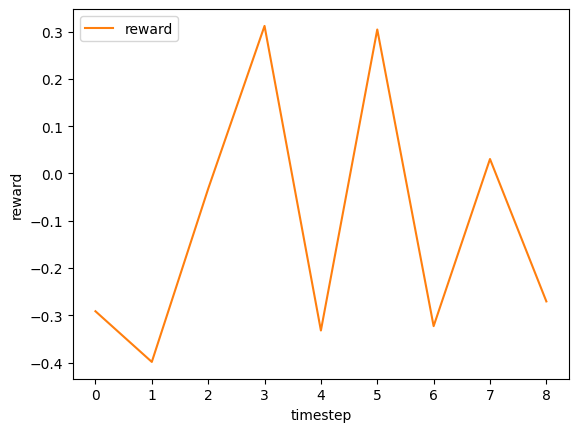

In [15]:
# let's visualize the transition of reward
def visualize_interaction_on_environment(env, agent):
    obs, info = env.reset()
    done = False
    reward_list = []

    while not done:
        action = agent.sample_action_online(obs)
        obs, reward, done, truncated, info = env.step(action)
        reward_list.append(reward)

    # plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(reward_list[:-1], label='reward', color='tab:orange')
    ax1.set_xlabel('timestep')
    ax1.set_ylabel('reward')
    ax1.legend(loc='upper left')
    plt.show()
    
visualize_interaction_on_environment(env, agent)

## 2. Standardized Environment

We provide the standardize basic synthetic environment in both discrete and continuous action cases.

In [16]:
# discrete setting
env = gym.make("BasicEnv-discrete-v0")
print(env.action_space)

Discrete(10)


In [17]:
# discrete setting
env = gym.make("BasicEnv-continuous-v0")
print(env.action_space)

Box(-1.0, 1.0, (3,), float64)


## 3. Customize Environmental Configuration
Now, we customize the Simulation environment.

We have the following environmental configurations:
- `step_per_episode`: Number of timesteps in an episode.
- `state_dim`: Dimension of the state.
- `action_type`: Action type of the RL agent.
- `n_actions`: Number of actions in the discrete action case.
- `action_dim`: Dimension of the action (context).
- `action_context`: Feature vectors that characterizes each action. Applicable only when action_type is "discrete".
- `reward_type`: Reward type.
- `reward_std`: Noise level of the reward. Applicable only when reward_type is "continuous".
- `obs_std`: Noise level of the state observation.
- `StateTransitionFunction`: State transition function.
- `RewardFunction`: Mean reward function.
- `random_state` : Random state.

#### Case 1. Customizing the Basic Setup

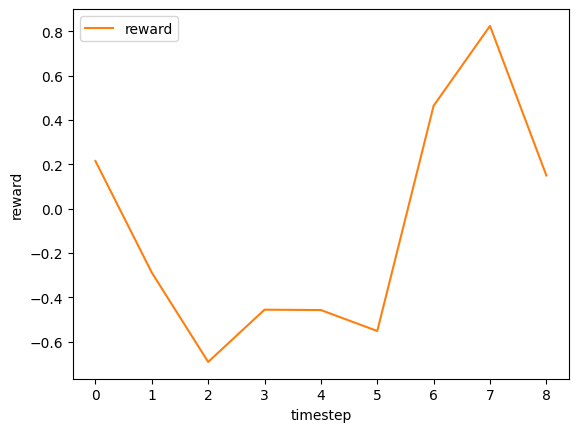

In [18]:
env = BasicEnv(
        state_dim=10,
        action_type="continuous",  # "discrete"
        action_dim=5,
        reward_type="continuous",  # "binary"
        reward_std=0.3,
        obs_std=0.3,
        step_per_episode=10,
        random_state=12345,
)
agent = OnlineHead(
    ContinuousRandomPolicy(
        action_scaler=MinMaxActionScaler(
            minimum=env.action_space.low,  # minimum value that policy can take
            maximum=env.action_space.high,  # maximum value that policy can take
            )
    ),
    name="random",
)
agent.build_with_env(env)
visualize_interaction_on_environment(env, agent)

#### Case 2. Using Customized StateTransitionFunction

In [19]:
@dataclass
class CustomizedStateTransitionFunction(BaseStateTransitionFunction):
    state_dim: int
    action_dim: int
    random_state: Optional[int] = None

    def __post_init__(self):
        self.random_ = check_random_state(self.random_state)
        self.state_coef = self.random_.normal(loc=0.0, scale=1.0, size=(self.state_dim, self.state_dim))
        self.action_coef = self.random_.normal(loc=0.0, scale=1.0, size=(self.state_dim, self.action_dim))

    def step(
        self,
        state: np.ndarray,
        action: np.ndarray,
    ) -> np.ndarray:
        state = self.state_coef @ state / self.state_dim +  self.action_coef @ action / self.action_dim
        state = state / np.linalg.norm(state, ord=2)
        return state

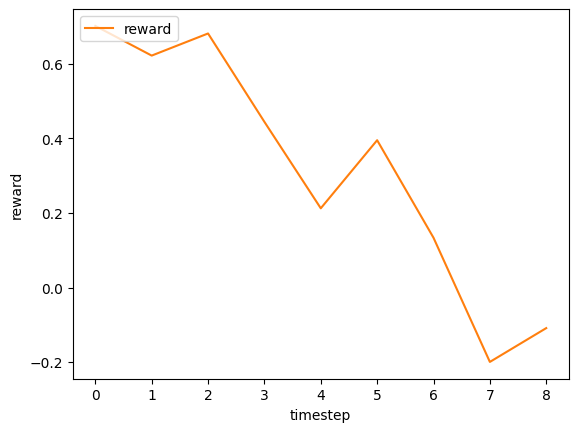

In [20]:
# setup environment
env = BasicEnv(
    StateTransitionFunction=CustomizedStateTransitionFunction,
    random_state=12345
)
agent = OnlineHead(
    ContinuousRandomPolicy(
        action_scaler=MinMaxActionScaler(
            minimum=env.action_space.low,  # minimum value that policy can take
            maximum=env.action_space.high,  # maximum value that policy can take
            )
    ),
    name="random",
)
agent.build_with_env(env)
visualize_interaction_on_environment(env, agent)

#### Case 3. Using Customized RewardFunction

In [21]:
@dataclass
class CustomizedRewardFunction(BaseRewardFunction):
    state_dim: int
    action_dim: int
    reward_type: str = "continuous"  # "binary"
    reward_std: float = 0.0
    random_state: Optional[int] = None

    def __post_init__(self):
        self.random_ = check_random_state(self.random_state)
        self.state_coef = self.random_.normal(loc=0.0, scale=1.0, size=(self.state_dim, ))
        self.action_coef = self.random_.normal(loc=0.0, scale=1.0, size=(self.action_dim, ))

    def mean_reward_function(
        self,
        state: np.ndarray,
        action: np.ndarray,
    ) -> float:
        reward = self.state_coef.T @ state / self.state_dim + self.action_coef.T @ action / self.action_dim
        return reward

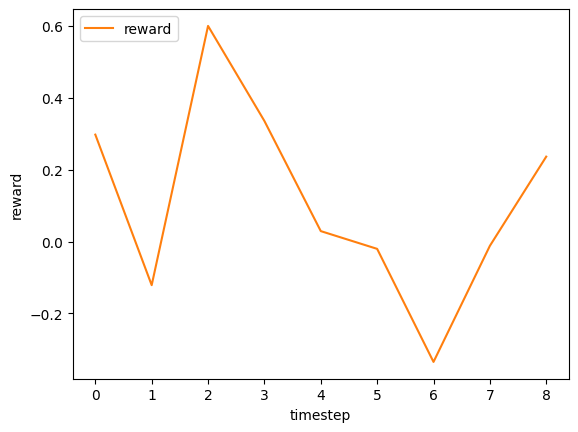

In [22]:
# setup environment
env = BasicEnv(
    RewardFunction=CustomizedRewardFunction,
    random_state=12345
)
agent = OnlineHead(
    ContinuousRandomPolicy(
        action_scaler=MinMaxActionScaler(
            minimum=env.action_space.low,  # minimum value that policy can take
            maximum=env.action_space.high,  # maximum value that policy can take
            )
    ),
    name="random",
)
agent.build_with_env(env)
visualize_interaction_on_environment(env, agent)

#### Case 4. Uning Customized Action Context in Discrete Action Setting

In [23]:
# we use the following action_context for synthetic 
# here, action_dim refers to the dimension of action_context
n_actions, action_dim = 10, 5
action_context = random_.normal(loc=0.0, scale=1.0, size=(n_actions, action_dim))

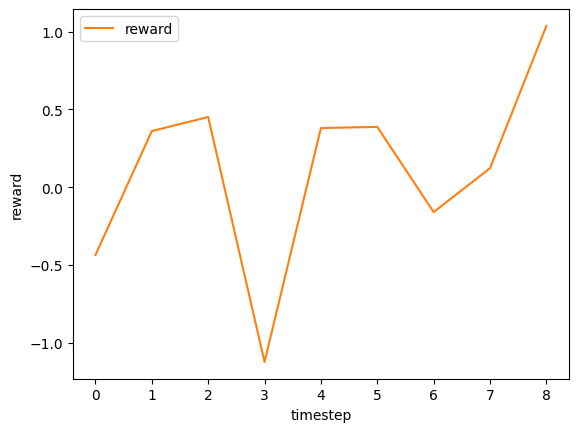

In [24]:
# using the above action_context, we can simulate an synthetic  as follows
env = BasicEnv(
        action_type="discrete",
        n_actions=10,
        action_dim=5,
        action_context=action_context,
        random_state = 12345,
)
agent = OnlineHead(
    DiscreteRandomPolicy(),
    name="random",
)
agent.build_with_env(env)
visualize_interaction_on_environment(env, agent)

For data collection and visualization, please refer to [examples/quickstart/basic/basic_synthetic_data_collection.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_data_collection.ipynb). 

For offline RL and OPE, please refer to [examples/quickstart/basic/basic_synthetic_discrete_basic.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_discrete_basic.ipynb) and [examples/quickstart/basic/basic_synthetic_continuous_basic.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_continuous_basic.ipynb).

For advanced topics regarding OPE and OPS, please refer to [examples/quickstart/basic/basic_synthetic_discrete_advanced.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_discrete_advanced.ipynb) and [examples/quickstart/basic/basic_synthetic_continuous_advanced.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_continuous_advanced.ipynb).

## Reference
- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.